In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

In [2]:
print(ctrl_mice)

('4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1', 'mCherry6', 'mCherry7', 'mCherry8', 'mCherry9')


In [3]:

figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [4]:
# replication of Losconczy preprint

# https://www.biorxiv.org/content/10.1101/2021.07.02.450956v1.full.pdf

# and sheffield 

# https://www-nature-com.stanford.idm.oclc.org/articles/s41467-021-23260-3#Sec8

In [5]:


def get_field_stats(field_mask):
#     sigfield_cells = field_mask.sum(axis=0)>0
    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask
#     _field_mask = 1.*field_mask
#     _field_mask = _field_mask[:,sigfield_cells]
    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
#     mask = field_widths>2
#     rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, n_perms = 1000, pcnt = 99):
    
    
    
    def _run_fields(nov):
        if nov:
            trial_mask = sess.trial_info['LR']==sess.novel_arm
        else:
            trial_mask = sess.trial_info['LR']== -1*sess.novel_arm
        shuff_mat = np.zeros([1000, *sess.trial_matrices['spks'].shape[1:]])
        trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]
        n_trials = trial_mat.shape[0]
        
        shuffs = rng.integers(trial_mat.shape[1], size = [n_perms, trial_mat.shape[0]])
        
        # calculate shuffles
        _tmat = 0*trial_mat
        for perm in range(n_perms):
            for trial in range(n_trials):
                _tmat[trial,:,:] = np.roll(trial_mat[trial,:,:], shuffs[perm, trial])
            shuff_mat[perm,:,:] = np.nanmean(_tmat, axis=0)
            
        thresh = np.nanpercentile(shuff_mat,pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    return {'fam': _run_fields(False), 'nov': _run_fields(True)}




In [6]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6))
ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ko_mice}
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [7]:
np.save('place_field_stats.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

In [6]:
_res = np.load("./place_field_stats.npy", allow_pickle=True).all()
ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

[0.         0.25974859 0.21908671 0.16944587 0.11210877 0.07388404
 0.05041047 0.03553104 0.02616727 0.01782966 0.01564905 0.00923551
 0.00461775 0.00628527]


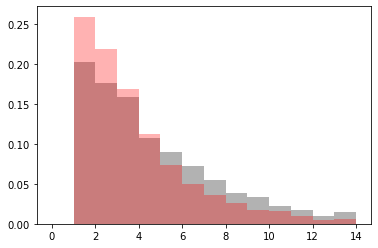

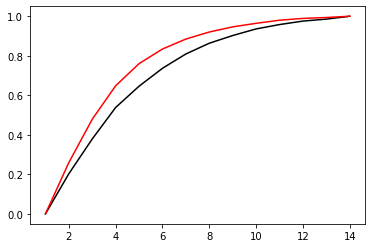

In [7]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['field_widths'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw, bins = np.arange(15), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color= 'black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['field_widths'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw, bins = np.arange(15), color = 'red', alpha = .3,density=True)
print(hist)


ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

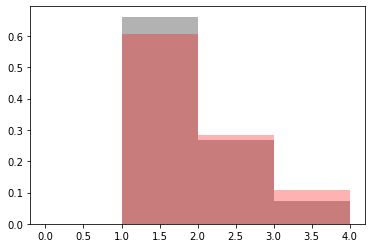

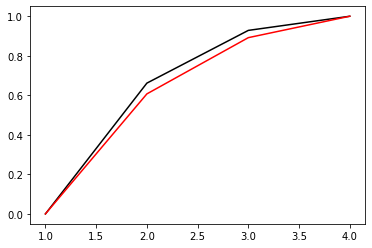

In [8]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['num_fields'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw[ctrl_fw>0], bins = np.arange(5), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['num_fields'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw[ko_fw>0], bins = np.arange(5), color = 'red', alpha = .3,density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


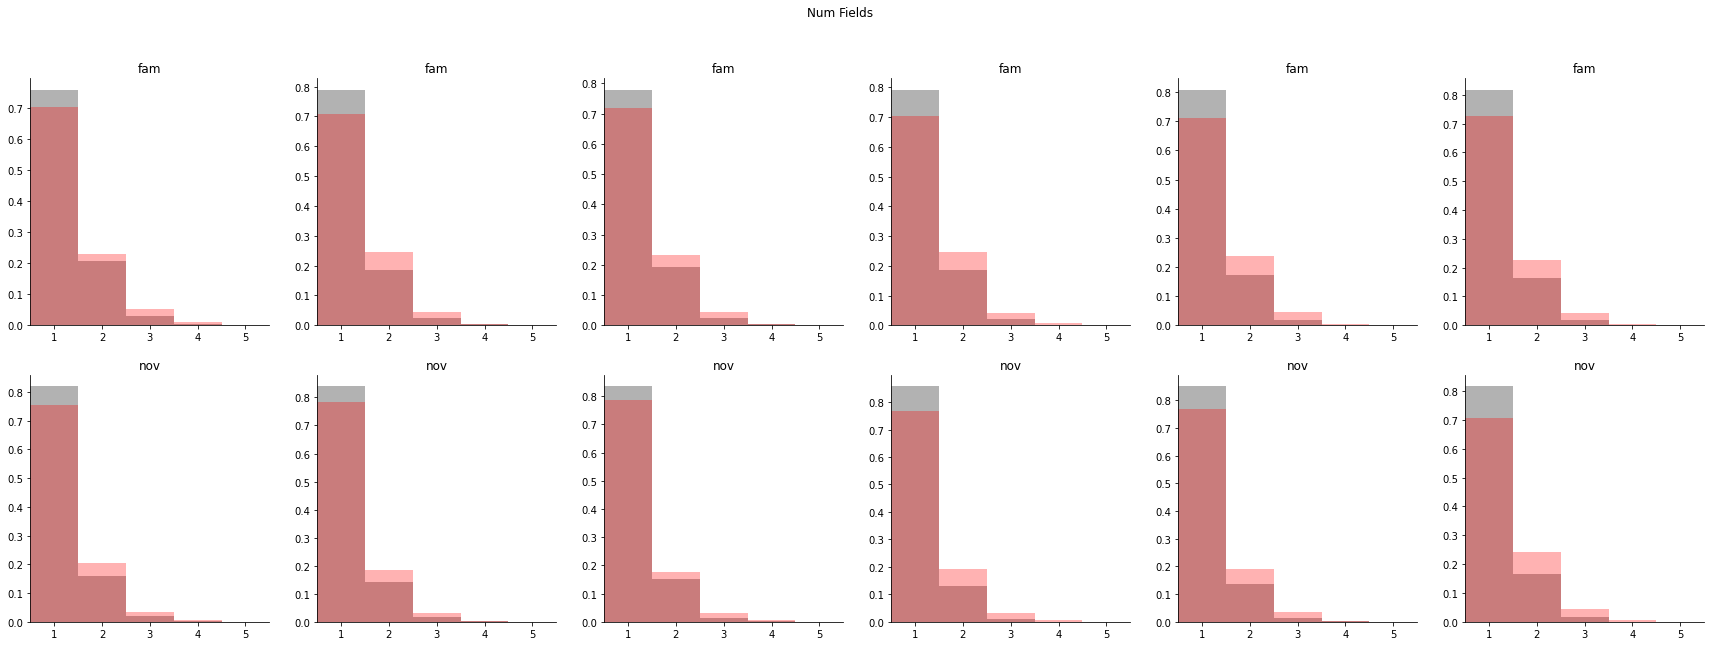

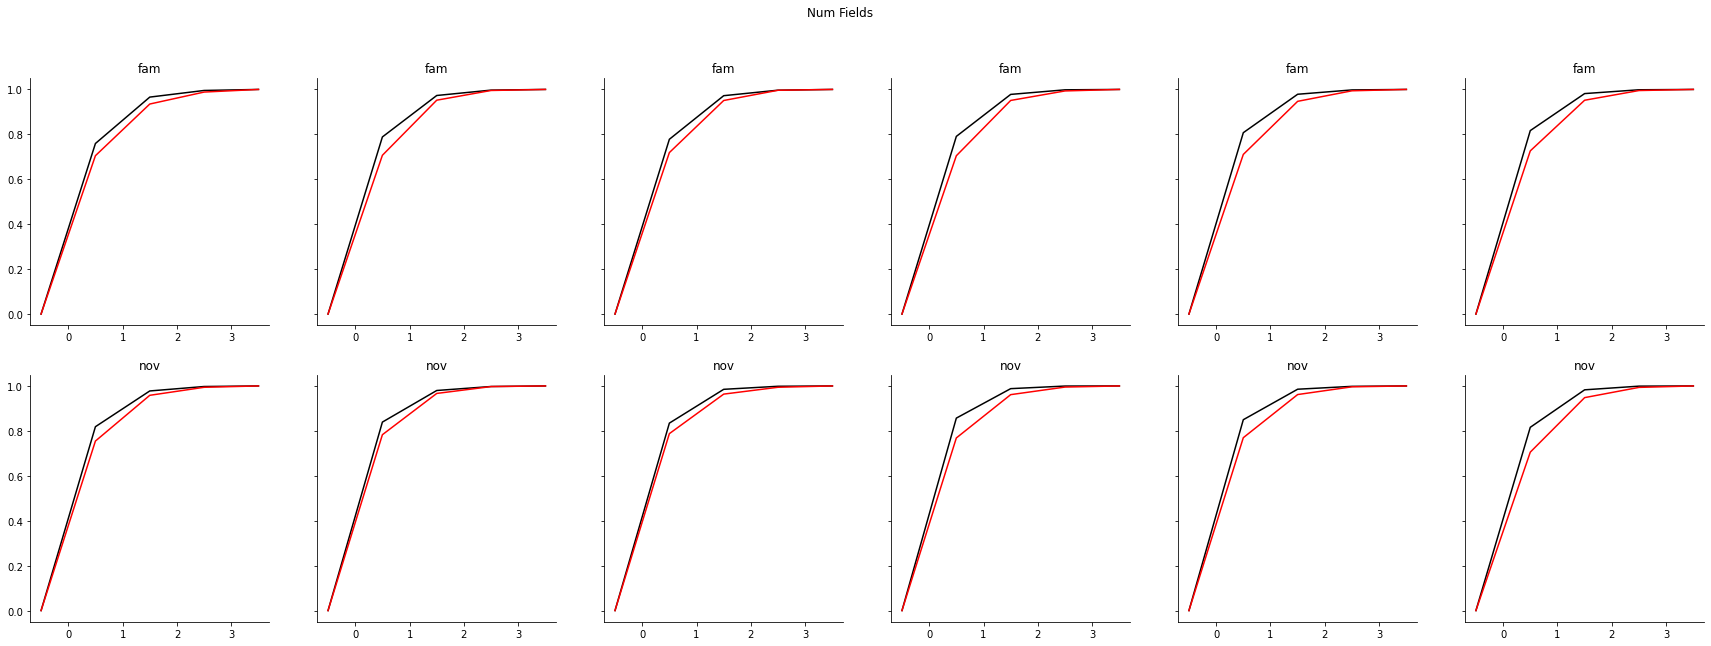

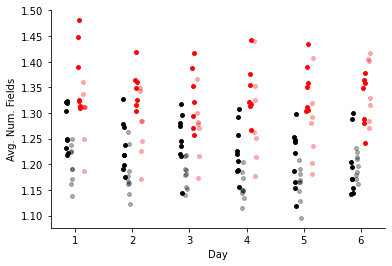

In [10]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize=[30,10],sharey=True)

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'day_norm': [],
                   'nov': [],
                   'num_fields' : [],
                   'mouse': [], 
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})

days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ctrl_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ctrl_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
# #             dat = f[:,1]-r[:,1]
            
            
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': day,
                            'day_norm': (day + 1)/6., #days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(-0.5,5,1), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax[row,day].set_xlim([.5,5.5])
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ko_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ko_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
#             dat = (fm[1:, :]>fm[:-1, :]).sum(axis=0)
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': day,
                            'day_norm': (day+1)/6., 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(-0.5,5,1), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Num Fields")
fig_cum.suptitle("Num Fields")

ax_scat.set_ylabel('Avg. Num. Fields')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"num_sig_fields_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"num_sig_fields_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

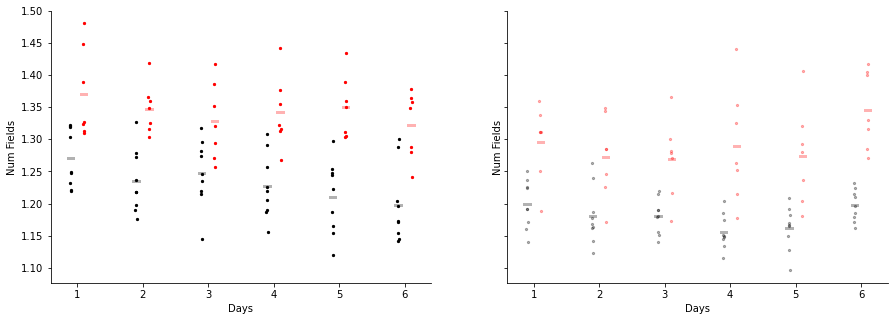

In [27]:
fig, ax = plt.subplots(1,2, figsize=[15,5],sharey=True)


for day in range(6):
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[0].scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=5)
    ax[0].plot(5*day  -.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[1].scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=5,alpha = .3)
    ax[1].plot(5*day  -.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==0)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[0].scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=5)
    ax[0].plot(5*day  +.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==1)
    frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[1].scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=5, alpha = .3)
    ax[1].plot(5*day  +.5 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("Num Fields")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
    
fig.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

-6.749336163504605 9.3292147232694e-06
-3.3343135813572675 0.0008551019694724832


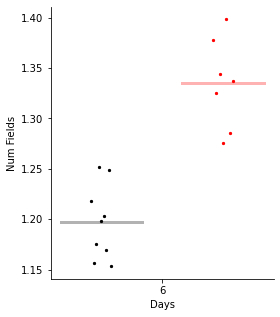

In [17]:
fig, ax = plt.subplots(figsize=[4,5],sharey=True)


day =5
mask = (df['ko']==0) & (df['day']==day) 
ctrl_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
ax.scatter(5*day-.3 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
ax.plot(5*day  -.3 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)

mask = (df['ko']==1) & (df['day']==day) 
ko_frac = np.array([df['num_fields'].loc[mask & (df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
ax.scatter(5*day+.3 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
ax.plot(5*day  +.3 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)


t,p = sp.stats.ttest_ind(ctrl_frac,ko_frac)
print(t,p)
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
print(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("Num Fields")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))
    
fig.savefig(os.path.join(figdir,"num_sig_fields_summary_short.pdf"))

In [28]:
res = mixed_anova(data = df[df['nov']==0], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.298594    1   14  0.298594  27.908340  0.000116  0.665938   
1          day  0.032943    5   70  0.006589   4.972955  0.000592  0.262108   
2  Interaction  0.008586    5   70  0.001717   1.296117  0.275539  0.084735   

        eps  
0       NaN  
1  0.677825  
2       NaN  
0.00011572197035229136


In [29]:
res = mixed_anova(data = df[df['nov']==1], dv= 'num_fields', between = 'ko', within = 'day', subject = 'mouse')
print(res)
print(res['p-unc'].iloc[0])

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.297436    1   14  0.297436  43.886574  0.000011  0.758148   
1          day  0.031782    5   70  0.006356   3.371559  0.008712  0.194085   
2  Interaction  0.011715    5   70  0.002343   1.242750  0.298618  0.081531   

        eps  
0       NaN  
1  0.589529  
2       NaN  
1.1423281353803488e-05


In [17]:
lmm_res = MixedLM(df['num_fields'], df[['ko', 
                                        'day', 
                                        'nov', 
                                        'ko_x_nov', 
                                        'ko_x_day',
                                        'nov_x_day',
                                        'speed',
                                        'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_fields
No. Observations: 192     Method:             REML      
No. Groups:       16      Scale:              0.0018    
Min. group size:  12      Log-Likelihood:     303.0512  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.038    0.017  2.330 0.020  0.006  0.071
day           -0.010    0.003 -2.844 0.004 -0.017 -0.003
nov           -0.100    0.015 -6.750 0.000 -0.130 -0.071
ko_x_nov      -0.001    0.012 -0.080 0.936 -0.025  0.023
ko_x_day       0.042    0.027  1.574 0.115 -0.010  0.094
nov_x_day      0.069    0.021  3.231 0.001  0.027  0.111
speed         -0.479    0.064 -7.507 0.000 -0.605 -0.354
intercept      1.417    0.022 63.896 0.00

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


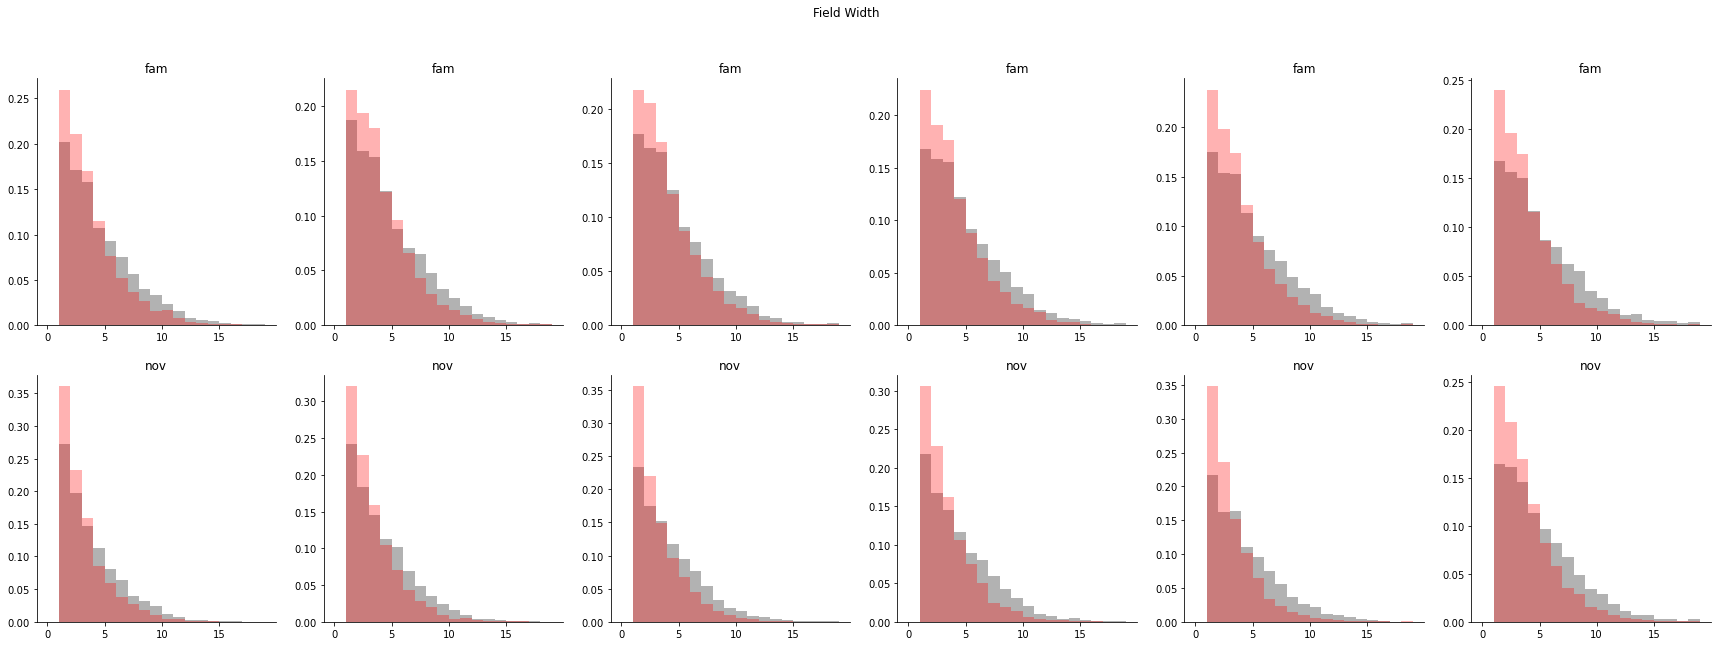

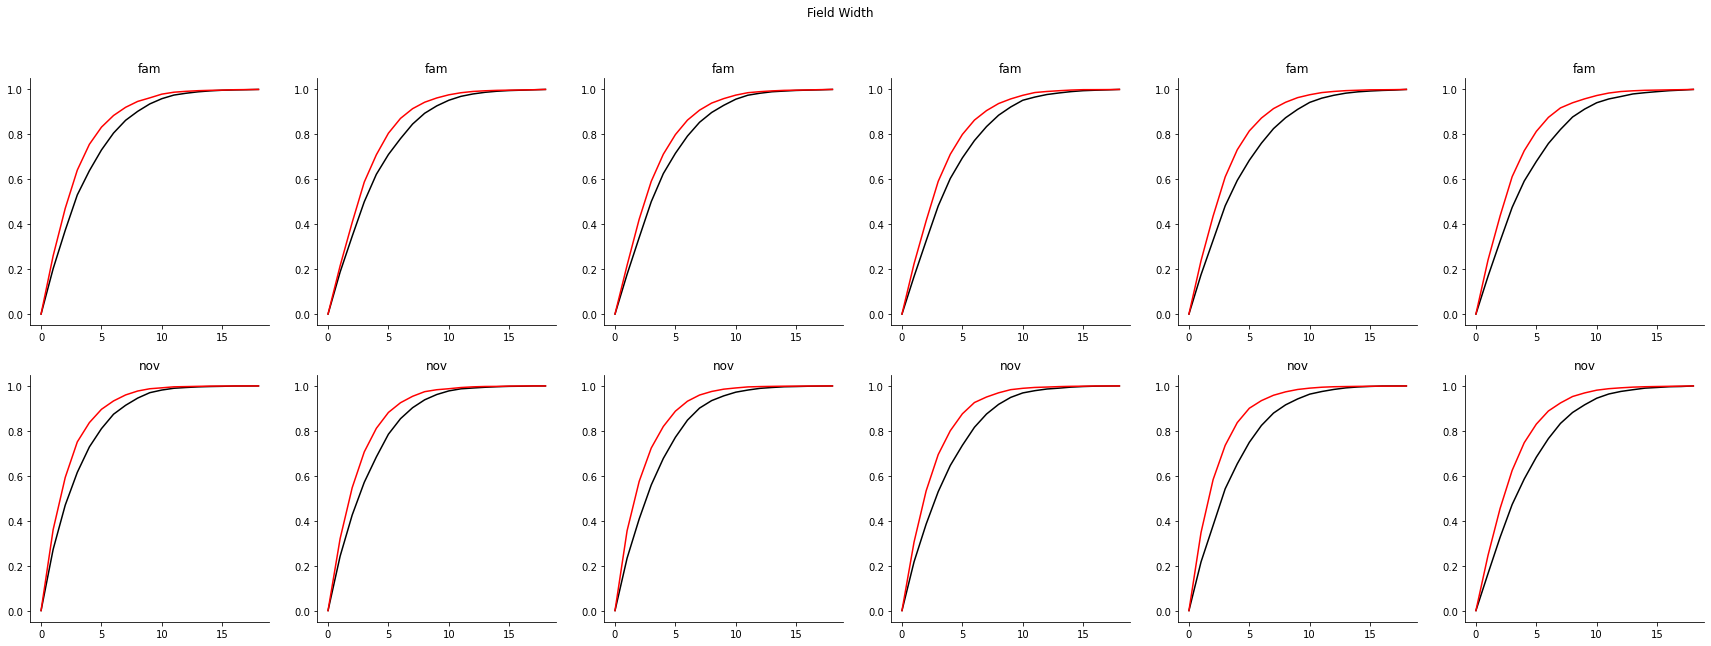

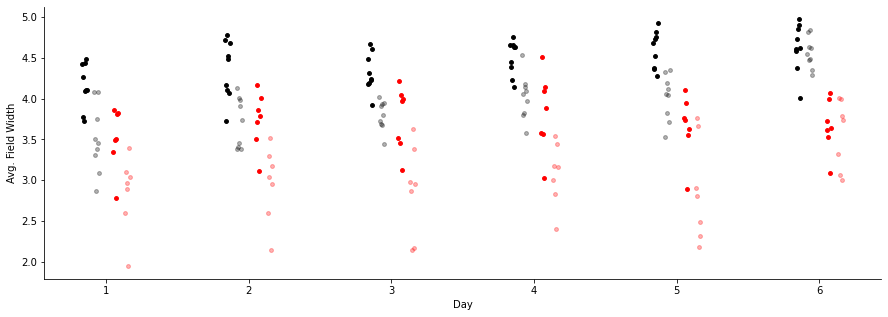

In [22]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize= [30,10])
fig_scat, ax_scat = plt.subplots( figsize= [15,5], sharey=True)
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'fw' : [],
                   'mouse': [],
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             print(dat)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': (day+1)/6.,
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        
        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(0,20), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             dat = ko_field_mask_res[mouse][day][novkey]['field_widths']
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': (day+1)/6., 
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

#         ax[row,day].hist(ko_fw, bins = np.arange(1,20), color = 'red', alpha = .3,density=True)
        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(0,20), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Field Width")
fig_cum.suptitle("Field Width")

ax_scat.set_ylabel('Avg. Field Width')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"field_width_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"field_width_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"field_width_summary.pdf"))
        

In [24]:
# _df = df[df['speed']>.05]
# _df['speed'] = sp.stats.zscore(df['speed']._values)
lmm_res = MixedLM(df['fw'],  df[['ko', 
                                 'day', 
                                 'nov', 
                                 'ko_x_nov', 
                                 'ko_x_day',
                                 'nov_x_day',
                                 'speed',
                                 'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fw      
No. Observations: 192     Method:             REML    
No. Groups:       16      Scale:              0.0509  
Min. group size:  12      Log-Likelihood:     -12.3144
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.100    0.089 -1.125 0.261 -0.275  0.075
day          0.366    0.136  2.700 0.007  0.100  0.632
nov         -0.756    0.080 -9.478 0.000 -0.912 -0.600
ko_x_nov    -0.162    0.066 -2.460 0.014 -0.290 -0.033
ko_x_day    -0.389    0.183 -2.123 0.034 -0.748 -0.030
nov_x_day    0.559    0.114  4.886 0.000  0.335  0.784
speed        3.943    0.400  9.851 0.000  3.158  4.727
intercept    2.889    0.138 20.935 0.000  2.619  3.160
day Var      0.080 

### Field edge analysis

In [59]:
def field_shifts(mouse, day, fm_res, novkey, pcnt_th = .25, act_th = .25, plot = False):
    sess = u.load_single_day(mouse,day)
    
    ledge, redge = fm_res[mouse][day][novkey]['rising_edges'], fm_res[mouse][day][novkey]['falling_edges']
    

    border_cells = (ledge[:,1]==0) #+ (redge[:,1]>=28) > 0
    ledge, redge = ledge[~border_cells,:], redge[~border_cells,:]
    
    arm_cells = .5*(redge[:,0]+ledge[:,0])>=0 #10
    ledge,redge = ledge[arm_cells,:], redge[arm_cells,:]
    ledge[:,1], redge[:,1] = np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29) #np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29)

    if novkey in ['fam']:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
        
        
    shift = []
    form_lap_vel = []
    field_width = []
    form_lap = []
    field_var = []
    mean_speed = []
    for field in range(ledge.shape[0]):
        fieldmat = sess.trial_matrices['spks'][trial_mask,:,:][:,np.maximum(ledge[field,1],0):redge[field,1],ledge[field,0]]
        speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
        fieldmat[np.isnan(fieldmat)]=1E-5
        activity_th = act_th*np.amax(fieldmat.ravel())
        fieldmat_th = np.amax(1*(fieldmat>activity_th), axis=1)
        formation_laps = fieldmat_th[:-4] * (sp.signal.convolve(fieldmat_th,np.ones([5,]), mode= 'valid')>=1) #(sp.ndimage.convolve1d(fieldmat_th, np.ones([5,]), mode='constant', cval = 0)>=1)
        if formation_laps.sum()>0:
            formation_lap = np.nonzero(formation_laps)[0][0]


            if fieldmat_th[formation_lap:].mean()>pcnt_th and redge[field,1]-ledge[field,1]>=3 and formation_laps.sum()>0:


    #             form_lap_vel.append(np.nanmean(speed[np.maximum(formation_lap-1,0):formation_lap+2]))
                form_lap_vel.append(speed[formation_lap])
                mean_speed.append(np.nanmean(speed[formation_lap:]))
                form_lap.append(formation_lap)
                field_width.append(redge[field,1]-ledge[field,1])

                form_argmax = sp.ndimage.center_of_mass(fieldmat[formation_lap,:])[0] 
    #             form_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[np.maximum(formation_lap-1,0):formation_lap+2,:],axis=0))[0] 
    #             print(form_argmax, sp.ndimage.center_of_mass(fieldmat[formation_lap,:]))
                field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]
    #             field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+2:,:], axis=0))[0] 

                shift.append(field_argmax-form_argmax)

                avg_act = np.nanmean(fieldmat[formation_lap:, :], axis=1)
                avg_act_norm = avg_act/np.nanmax(avg_act)
                field_var.append(np.nanvar(avg_act_norm))

                if plot:
                    fig, ax = plt.subplots(1,2, figsize= [10,5])
                    ax[0].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                    ax[0].vlines([ledge[field,1], redge[field,1]], 0, trial_mask.sum(), color= 'blue')
                    ax[0].hlines(formation_lap, 0,30)
                    ax[0].scatter(form_argmax+ ledge[field,1],formation_lap,color='green')
                    ax[0].vlines(field_argmax + ledge[field,1], 0 , trial_mask.sum(), color='red')
                    ax[0].set_title("%d" % field)

                    ax[1].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')

                    mousedir = os.path.join(figdir, sess.mouse) 
                    os.makedirs(mousedir, exist_ok = True)
                    fig.savefig(os.path.join(mousedir, "field_%d.pdf" % field))

    return {'shift': np.array(shift), 
            'formation_lap': np.array(form_lap), 
            'width': np.array(field_width), 
            'init_speed': np.array(form_lap_vel),
            'speed': np.array(mean_speed),
            'field_var': np.array(field_var)}

In [60]:

_ = field_shifts(ctrl_mice[5], 0, ctrl_field_mask_res, 'nov', plot=False, act_th = .2, pcnt_th = .5)

{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


In [61]:
_ = field_shifts(ko_mice[-1], 0, ko_field_mask_res, 'nov', plot=False, act_th=.2)

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}


In [62]:
ctrl_nov_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'nov', act_th = .2, pcnt_th = .5) for day in range(6)] for mouse in ctrl_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

<ipython-input-59-16c020c11dad>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [63]:
ko_nov_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'nov', act_th = .2, pcnt_th = .5) for day in range(6)] for mouse in ko_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [64]:
ctrl_fam_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'fam', act_th = .2, pcnt_th = .5) for day in range(6)] for mouse in ctrl_mice}
ko_fam_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'fam', act_th = .2, pcnt_th = .5) for day in range(6)] for mouse in ko_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

<ipython-input-59-16c020c11dad>:28: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{

In [65]:
df_shifts = pd.DataFrame({'mouse': [],
                          'm': [],
                          'day': [],
                         'dz': [],
                         'ko': [],
                         'nov': [],
                         'nov_x_dz': [],
                         'ko_x_dz': [],
                         'ko_x_nov': [],
                         'ko_x_nov_x_dz':[],
                         'shifts': [],
                         'width': [],
                         'formation_lap': [],
                         'init_speed': [],
                         'init_speed_x_ko': [],
                         'speed': [],
                         'ko_x_speed': [],
                         'field_var': [],
                         'ko_x_speed': [], 
                         'intercept': []})


days_z = sp.stats.zscore(np.arange(6))
for day, dz in enumerate(days_z):
    print('day', day)
    
    for m, mouse in enumerate(ctrl_mice):
        
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ctrl_nov_shifts[mouse][day]['shift'], 
                                                                                   ctrl_nov_shifts[mouse][day]['width'], 
                                                                                   ctrl_nov_shifts[mouse][day]['init_speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['speed'],
                                                                                   ctrl_nov_shifts[mouse][day]['formation_lap'],
                                                                                   ctrl_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 1,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ctrl_fam_shifts[mouse][day]['shift'], 
                                                                                    ctrl_fam_shifts[mouse][day]['width'], 
                                                                                    ctrl_fam_shifts[mouse][day]['init_speed'],
                                                                                   ctrl_fam_shifts[mouse][day]['speed'],
                                                                                    ctrl_fam_shifts[mouse][day]['formation_lap'],
                                                                                    ctrl_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 0,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': 0,
                                              'speed': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)

    for m, mouse in enumerate(ko_mice):
        
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ko_nov_shifts[mouse][day]['shift'], 
                                                                                    ko_nov_shifts[mouse][day]['width'], 
                                                                                    ko_nov_shifts[mouse][day]['init_speed'],
                                                                                   ko_nov_shifts[mouse][day]['speed'],
                                                                                    ko_nov_shifts[mouse][day]['formation_lap'],
                                                                                    ko_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 1,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 1,
                                              'ko_x_nov_x_dz': 1,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': init_speed,
                                              'init_speed_x_ko': init_speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, init_speed, speed, formlap, fvar) in enumerate(zip(ko_fam_shifts[mouse][day]['shift'], 
                                                        ko_fam_shifts[mouse][day]['width'], 
                                                        ko_fam_shifts[mouse][day]['init_speed'],
                                                                                   ko_fam_shifts[mouse][day]['speed'],
                                                        ko_fam_shifts[mouse][day]['formation_lap'],
                                                        ko_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 0,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'speed': speed,
                                              'ko_x_speed': speed, 
                                              'intercept': 1}, ignore_index=True)


day 0
day 1
day 2
day 3
day 4
day 5


In [66]:
df_shifts.to_pickle("./df_shifts.pkl")

In [99]:
df_shifts = pd.read_pickle("./df_shifts.pkl")

0.6069888201501638 0.543889023005794
1.449278889518986 0.14731972744493047
0.849303994195198 0.3957439507943574
4.275505517616174 1.93426196902055e-05
-0.6144939755523973 0.5389077688742057
0.21731896370322173 0.8279661302648559
1.4403301328540385 0.14981561724786127
-0.12643511610135513 0.8993910791303374
-0.43563066137466183 0.6631178750983436
-0.32963733125611405 0.7416847189428157
-0.3148631015688667 0.7528737126120172
2.8382478548803407 0.004548322302576064


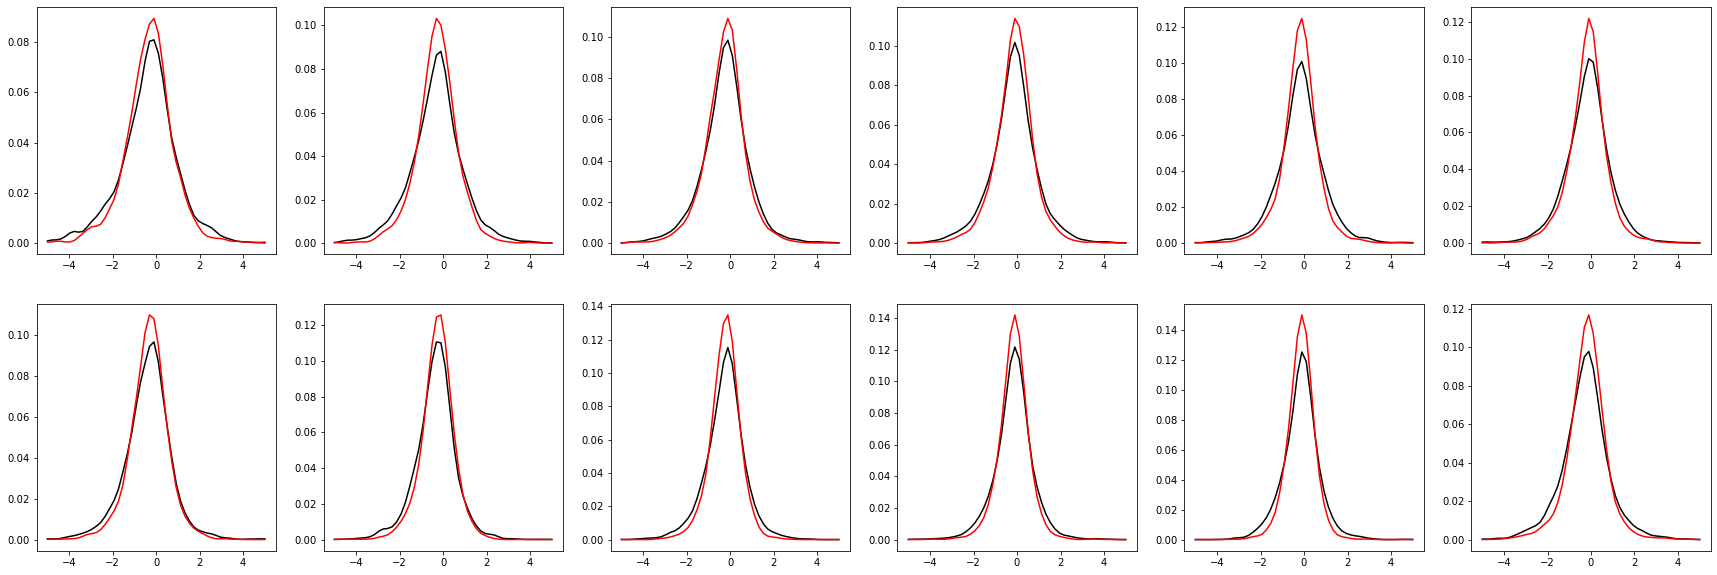

In [100]:
fig, ax = plt.subplots(2,6, figsize= [30,10])

x = np.linspace(-5,5)
for day in range(6):
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) & (df_shifts['speed']>0.05) & (df_shifts['nov']==0)
    ctrl_shifts = df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],.3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='black')
#     ax[0,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1) & (df_shifts['speed']>0.05) & (df_shifts['nov']==0)
    ko_shifts = df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],.3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[0,day].plot(x,hist, color='red')
#     ax[0,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==0) & (df_shifts['init_speed']>0.05) & (df_shifts['nov']==1)
    ctrl_shifts = df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],.3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='black')
#     ax[1,day].plot(ctrl_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    mask = (df_shifts['day']==day) & (df_shifts['ko']==1) & (df_shifts['init_speed']>0.05) & (df_shifts['nov']==1)
    ko_shifts = df_shifts['shifts'].loc[mask]._values
    hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],.3, x[:,np.newaxis]).mean(axis=1)
    hist /= hist.sum()
    ax[1,day].plot(x,hist, color='red')
#     ax[1,day].plot(ko_shifts.mean()*np.ones([2,]), [0,np.amax(hist)])
    
    t,p = sp.stats.ttest_ind(ko_shifts,ctrl_shifts)
#     t,p = sp.stats.ttest_1samp(ctrl_shifts, 0) #,ctrl_shifts)
    print(t,p)
    
# fig.savefig(os.path.join(figdir, "com_shift_by_day.pdf"), format = 'pdf')

In [70]:
aov = mixed_anova(data = df[df['nov'] == 1], dv = 'shifts', between = 'ko', within= 'day', subject = 'm')
print(aov)

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/pingouin/parametric.py:552: RuntimeWarning: invalid value encountered in double_scalars
  ms_with = ss_with / ddof1
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/pingouin/parametric.py:553: RuntimeWarning: invalid value encountered in double_scalars
  ms_reswith = ss_reswith / ddof2
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/pingouin/parametric.py:563: RuntimeWarning: invalid value encountered in double_scalars
  ef = ss_with / (ss_with + ss_reswith)


KeyError: 'MS'

In [26]:
print(df_shifts[df_shifts['ko']==0].shape)
print(df_shifts[df_shifts['ko']==1].shape)

(42683, 19)
(38414, 19)


In [103]:

df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
                                  'dz', 
                                  'nov',
                                  'nov_x_dz', 
                                  'ko_x_dz', 
                                  'ko_x_nov', 
                                  'init_speed',  
                                  'init_speed_x_ko',
                                  'speed',
                                  'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-103-efa2b24fa01f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-103-efa2b24fa01f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-103-efa2b24fa01f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: shifts     
No. Observations:   65584   Method:             REML       
No. Groups:         16      Scale:              0.9855     
Min. group size:    2057    Log-Likelihood:     -92655.7426
Max. group size:    8198    Converged:          Yes        
Mean group size:    4099.0                                 
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko               0.002    0.110   0.020 0.984 -0.213  0.217
dz               0.098    0.008  11.583 0.000  0.081  0.114
nov              0.035    0.011   3.157 0.002  0.013  0.057
nov_x_dz         0.015    0.010   1.577 0.115 -0.004  0.035
ko_x_dz         -0.027    0.010  -2.695 0.007 -0.046 -0.007
ko_x_nov        -0.022    0.016  -1.348 0.178 -0.053  0.010
init_speed      -0.114    0.008 -14.074 0.000 -0.13

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [104]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']==0)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)
lmm_res = MixedLM(df['shifts'], df[['ko', 
#                                   'dz', 
                                  'nov',
#                                   'nov_x_dz', 
#                                   'ko_x_dz', 
                                  'ko_x_nov', 
                                  'init_speed',  
                                  'init_speed_x_ko',
#                                     'speed',
#                                     'ko_x_speed',
                                  'intercept']], 
                                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shifts     
No. Observations:  9853    Method:             REML       
No. Groups:        16      Scale:              0.9859     
Min. group size:   271     Log-Likelihood:     -13940.5398
Max. group size:   1301    Converged:          Yes        
Mean group size:   615.8                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.015    0.063 -0.238 0.812 -0.139  0.109
nov              0.019    0.028  0.682 0.495 -0.036  0.075
ko_x_nov        -0.000    0.041 -0.004 0.997 -0.081  0.081
init_speed      -0.101    0.016 -6.525 0.000 -0.132 -0.071
init_speed_x_ko  0.127    0.026  4.962 0.000  0.077  0.177
intercept        0.032    0.042  0.749 0.454 -0.051  0.114
Group Var        0.012    0.005                           



<ipython-input-104-4a30aabe9389>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-104-4a30aabe9389>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-104-4a30aabe9389>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

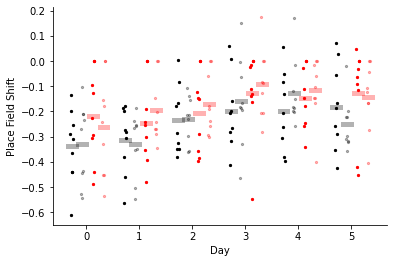

In [105]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0) & (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


    
for day in range(6):
    
    ax.scatter(day - .3 + np.linspace(0,.05, num = plot_arr.shape[2]), plot_arr[0,0,:,day], color = 'black', s = 5 )
    ax.plot(day -.3 + np.array([-.05,.1]), np.nanmean(plot_arr[0,0,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.275], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,0,:,day], nan_policy='omit')],width = .15, edgecolor='black', fill=False)
    
    ax.scatter(day -.1 + np.linspace(0,.05, num = plot_arr.shape[2]), plot_arr[0,1,:,day], color = 'black', s = 5 , alpha = .3)
    ax.plot(day -.1 + np.array([-.05,.1]), np.nanmean(plot_arr[0,1,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.075], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,1,:,day], nan_policy='omit')],width = .15, edgecolor='black',alpha = .3, fill=False)
    
    ax.scatter(day + .1 + np.linspace(0,.05, num = plot_arr.shape[2]), plot_arr[1,0,:,day], color = 'red', s = 5 )
    ax.plot(day +.1 + np.array([-.05,.1]), np.nanmean(plot_arr[1,0,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.125], [np.nanmean(plot_arr[1,0,:,day])],yerr = [sp.stats.sem(plot_arr[1,0,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = 1, fill=False)
    
    
    ax.scatter(day +.3 + np.linspace(0,.05, num = plot_arr.shape[2]), plot_arr[1,1,:,day], color = 'red', s = 5 , alpha = .3)
    ax.plot(day +.3 + np.array([-.05,.1]), np.nanmean(plot_arr[1,1,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.325], [np.nanmean(plot_arr[1,1,:,day])],yerr = [sp.stats.sem(plot_arr[1,1,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = .3, fill=False)
    
    
# ax.set_xticks(10*np.arange(6)+2)
# ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Shift')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

In [106]:
for day in range(6):
    t,p = sp.stats.ttest_ind(plot_arr[0,0,:,day],plot_arr[1,0,:,day], nan_policy = 'omit')
    print(t,p)

-1.5558716497693892 0.13929526335069095
-0.9686536933939504 0.34713359241273134
-0.4284016510378099 0.6740701287295968
-0.9450834036350673 0.3586708150409278
-0.783477802076093 0.44479020061951535
-0.6824678363059379 0.5047047402917787


In [109]:
df = df_shifts[(df_shifts['speed']>0.05) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['field_var'] = sp.stats.zscore(df['field_var']._values)
lmm_res = MixedLM(df['field_var'], df[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov',  'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-109-79ba61c8110d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-109-79ba61c8110d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-109-79ba61c8110d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 65584   Method:             REML       
No. Groups:       16      Scale:              0.7123     
Min. group size:  2057    Log-Likelihood:     -81998.0946
Max. group size:  8198    Converged:          Yes        
Mean group size:  4099.0                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko            -0.050    0.090  -0.552 0.581 -0.227  0.127
dz            -0.100    0.007 -13.976 0.000 -0.114 -0.086
nov            0.932    0.009 100.954 0.000  0.914  0.950
nov_x_dz      -0.076    0.008  -9.113 0.000 -0.092 -0.059
ko_x_dz        0.093    0.008  11.105 0.000  0.076  0.109
ko_x_nov       0.112    0.013   8.458 0.000  0.086  0.138
intercept     -0.484    0.060  -8.100 0.000 -0.601 -0.367
Group Var      0.032    

In [111]:
aov = mixed_anova(data = df[df['nov'] == 0], dv = 'field_var', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.071484    1   14  0.071484  0.503345  0.489682        NaN   
1          day  0.356273    4   56  0.089068  5.560707  0.000768   0.006293   
2  Interaction  0.100493    4   56  0.025123  1.568493  0.195367        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.034705       NaN        NaN       NaN       NaN  
1  0.284279  0.600078      False  0.211361  0.013979  
2  0.100748       NaN        NaN       NaN       NaN  


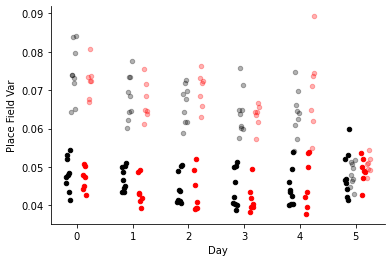

In [112]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Var')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir, "field_var_summary.pdf"))

In [114]:
df = df_shifts[(df_shifts['speed']>0.01) & (df_shifts['day']<5)]
speed_z = sp.stats.zscore(df['init_speed']._values)
df['init_speed'] = speed_z
df['init_speed_x_ko'] = speed_z*df['ko']._values
speed_z = sp.stats.zscore(df['speed']._values)
df['speed'] = speed_z
df['ko_x_speed'] = speed_z*df['ko']._values
df['shifts'] = sp.stats.zscore(df['shifts']._values)

lmm_res = MixedLM(df['width'], df[['ko', 
                                 'dz', 
                                 'nov',
                                 'nov_x_dz', 
                                 'ko_x_dz', 
                                 'ko_x_nov', 
                                 'init_speed',  
                                 'init_speed_x_ko', 
                                 'speed', 
                                 'ko_x_speed',
                                 'intercept']], 
                  df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

<ipython-input-114-66aa9be0e033>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed'] = speed_z
<ipython-input-114-66aa9be0e033>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['init_speed_x_ko'] = speed_z*df['ko']._values
<ipython-input-114-66aa9be0e033>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: width       
No. Observations:  66172   Method:             REML        
No. Groups:        16      Scale:              8.3568      
Min. group size:   2072    Log-Likelihood:     -164199.7123
Max. group size:   8457    Converged:          Yes         
Mean group size:   4135.8                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko              -0.155    0.314  -0.492 0.623 -0.771  0.462
dz              -0.042    0.025  -1.722 0.085 -0.090  0.006
nov             -0.818    0.033 -25.140 0.000 -0.882 -0.754
nov_x_dz         0.085    0.028   3.007 0.003  0.030  0.141
ko_x_dz         -0.068    0.029  -2.394 0.017 -0.124 -0.012
ko_x_nov         0.003    0.046   0.056 0.955 -0.088  0.093
init_speed       0.098    0.024   4.099 0.000  0.05

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


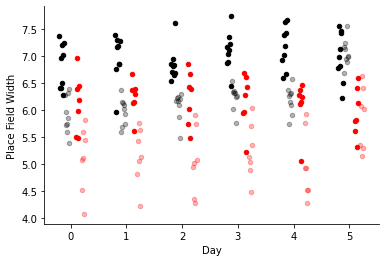

In [115]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 9, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

In [45]:
t,p = sp.stats.ttest_ind(plot_arr[0,0,:,0],plot_arr[1,0,:,0])
print(t,p)

2.2204814538609745 0.041175546614633574


2.593947266513435 0.009518798420886583
7.906309280997997 3.1008537248455335e-15
-3.354543095535321 0.0007989507873125426
0.45398964996193425 0.6498495313791897
-8.879081618819981 8.423398281263824e-19
-8.226863318673951 2.2246296188019783e-16


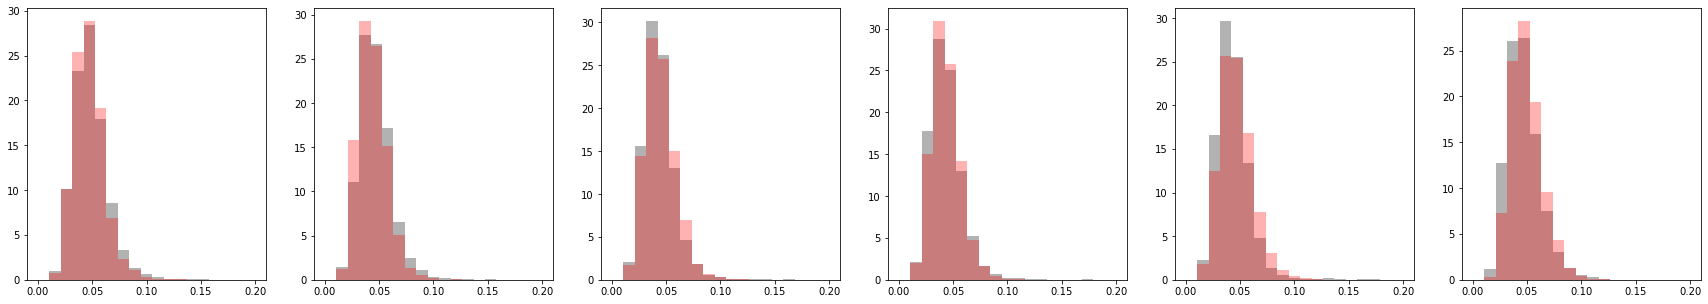

In [46]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.linspace(0,.2, num=20)
for day in range(6):
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                             df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)])
    print(t,p)

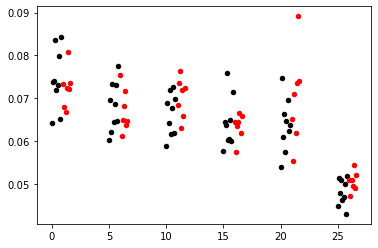

In [47]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)
    

In [90]:
lmm_res = MixedLM(df_shifts['field_var'], df_shifts[['ko', 'dz', 'ko_x_dz','nov', 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 81919   Method:             REML       
No. Groups:       16      Scale:              0.0003     
Min. group size:  2577    Log-Likelihood:     210204.0549
Max. group size:  10757   Converged:          Yes        
Mean group size:  5119.9                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             0.000    0.002   0.012 0.991 -0.004  0.004
dz            -0.004    0.000 -41.932 0.000 -0.004 -0.004
ko_x_dz        0.002    0.000  11.354 0.000  0.001  0.002
nov            0.018    0.000 140.155 0.000  0.018  0.018
intercept      0.046    0.001  36.674 0.000  0.044  0.049
Group Var      0.000    0.000                            



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(5283, 19) -0.08858960852043558 1.1168033515018665e-10
(4436, 19) 0.01859566620030598 0.21560824957740682


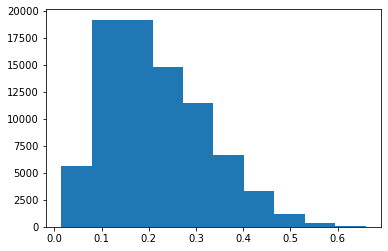

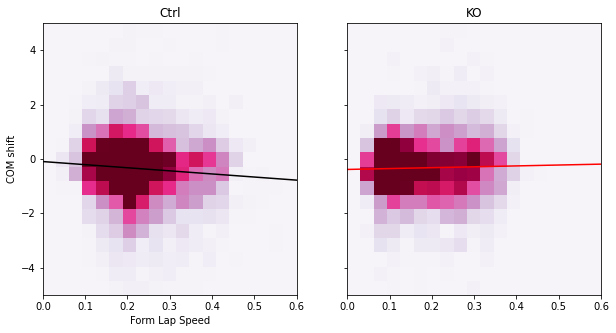

In [116]:
fig, ax = plt.subplots()
ax.hist(df_shifts['init_speed'])

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['shifts'], bins=(np.linspace(0,.6,num=20),np.linspace(-5,5,num=20)),density=True, vmax = 1, cmap = 'PuRd') #, color='black')

res = sp.stats.linregress(ctrl_df['init_speed'],ctrl_df['shifts'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['init_speed'],ctrl_df['shifts'])
r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['shifts'])
print(ctrl_df.shape,r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
ax[1].hist2d(ko_df['init_speed'],ko_df['shifts'], bins=(np.linspace(0,.6,num=20),np.linspace(-5,5,num=20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['init_speed'],ko_df['shifts'])
r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['shifts'])

res = sp.stats.linregress(ko_df['init_speed'], ko_df['shifts'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(ko_df.shape,r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('COM shift')
fig.savefig(os.path.join(figdir,"initspeed_vs_shifts.pdf"))

0
[0.         0.03157895 0.06315789 0.09473684 0.12631579 0.15789474
 0.18947368 0.22105263 0.25263158 0.28421053 0.31578947 0.34736842
 0.37894737 0.41052632 0.44210526 0.47368421 0.50526316 0.53684211
 0.56842105 0.6       ] [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
0.21612405935069715 7.053063233278633e-57
0.1907249903928396 1.3143142410427634e-37


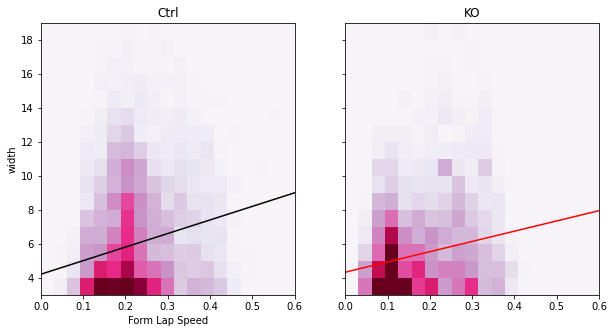

In [117]:

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) & (df_shifts['init_speed']>0.05)]
h, xedges, yedges, _ = ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)),density=True, vmax = 1, cmap = 'PuRd') #, color='black')
print(np.isnan(h).sum())
print(xedges, yedges)

res = sp.stats.linregress(ctrl_df['speed'],ctrl_df['width'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['speed'],ctrl_df['width'])
r,p = sp.stats.spearmanr(ctrl_df['speed'],ctrl_df['width'])
print(r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0)& (df_shifts['init_speed']>0.05)]
ax[1].hist2d(ko_df['init_speed'],ko_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['speed'],ko_df['width'])
r,p = sp.stats.spearmanr(ko_df['speed'],ko_df['width'])

res = sp.stats.linregress(ko_df['speed'], ko_df['width'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('width')
fig.savefig(os.path.join(figdir,"initspeed_vs_width.pdf"))

In [98]:
speed_z = sp.stats.zscore(df_shifts['init_speed']._values)
df_shifts['init_speed'] = speed_z
df_shifts['init_speed_x_ko'] = speed_z*df_shifts['ko']._values
speed_z = sp.stats.zscore(df_shifts['speed']._values)
df_shifts['speed'] = speed_z
df_shifts['ko_x_speed'] = speed_z*df_shifts['ko']._values
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 
                                                 'dz', 
                                                 'ko_x_dz',
                                                 'init_speed', 
                                                 'init_speed_x_ko',
                                                 'speed',
                                                 'ko_x_speed',
                                                 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: width       
No. Observations: 81919   Method:             REML        
No. Groups:       16      Scale:              8.8174      
Min. group size:  2577    Log-Likelihood:     -205443.9679
Max. group size:  10757   Converged:          Yes         
Mean group size:  5119.9                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.145    0.160 -0.907 0.364 -0.459  0.169
dz               0.118    0.015  7.997 0.000  0.089  0.147
ko_x_dz         -0.100    0.022 -4.625 0.000 -0.142 -0.058
init_speed       0.004    0.022  0.179 0.858 -0.039  0.046
init_speed_x_ko  0.504    0.051  9.895 0.000  0.404  0.604
speed            1.129    0.024 47.844 0.000  1.083  1.176
ko_x_speed      -0.494    0.056 -8.758 0.000 -0.605 -0.384
intercep

4.32985666750674 1.506732705320439e-05
4.923124922466533 8.62185034765361e-07
3.7686532374107156 0.0001647742172751671
5.623542450468324 1.904791192579001e-08
7.231255940675014 5.036115584842501e-13
4.732129066650255 2.241080053999211e-06


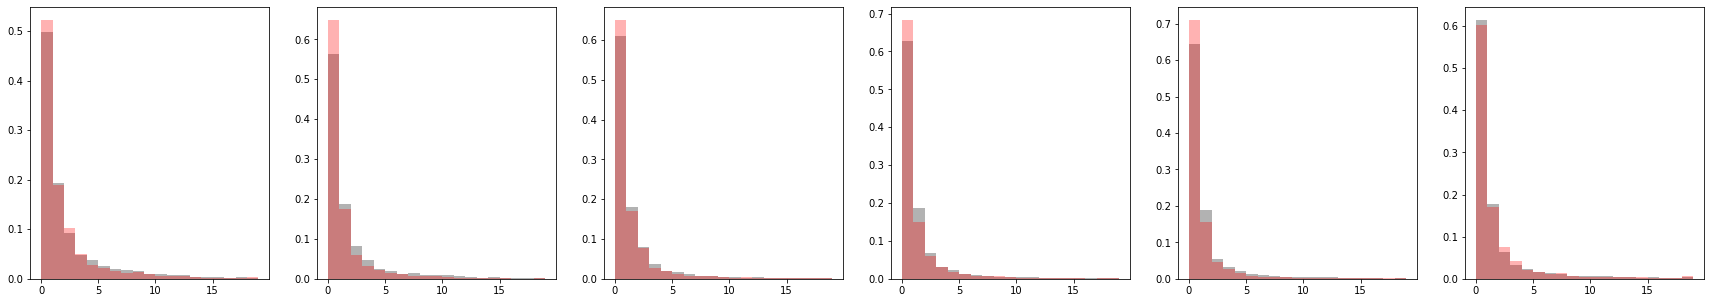

In [118]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.arange(20)
for day in range(6):
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) ],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],
                             df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)])
    print(t,p)

In [119]:
lmm_res = MixedLM(df_shifts['formation_lap'], df_shifts[['ko', 'dz', 'ko_x_dz']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: formation_lap
No. Observations: 81919   Method:             REML         
No. Groups:       16      Scale:              87.8247      
Min. group size:  2577    Log-Likelihood:     -299594.5994 
Max. group size:  10757   Converged:          Yes          
Mean group size:  5119.9                                   
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
ko            2.093     0.965   2.170  0.030   0.202   3.985
dz           -0.353     0.046  -7.600  0.000  -0.444  -0.262
ko_x_dz       0.055     0.068   0.817  0.414  -0.077   0.188
Group Var     6.497     0.254                               

